### Abstract

In this notebook I work with data from APTOS 2019 Blindness Detection competition where we find the severity of diabetic retinopathy using the image data and also we go through various hyperparmeters and find which the best paramteres to detect retinopathy, As the data is imbalanced in the continuing notebook i have augmneted the data and had better model in identifying diabetic retinopathy, With the better hyperparamteres from this notebook we are able to predict diabetic retinopathy with f1score of 67 which is high compartive the model without data augmentation. 

### Diabetic Retinopathy
Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy, with performance that can exceed that of in-person dilated eye examinations.

<center>
<img src="images/main.jpg" />
</center>

### A look into the data

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Your task is to create an automated analysis system capable of assigning a score based on this scale.

### Reading data and Basic EDA
Here I am going to open the dataset with pandas, check distribution of labels.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Any results you write to the current directory are saved as output.

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image

In [3]:
sample_submission = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")

In [4]:
train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [5]:
test.head()

id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

In [6]:
test.shape

(1928, 1)

In [7]:
train.shape

(3662, 2)

In [8]:
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(5)

diagnosis                                               path
0          2  ../input/aptos2019-blindness-detection/train_i...
1          0  ../input/aptos2019-blindness-detection/train_i...
2          4  ../input/aptos2019-blindness-detection/train_i...
3          0  ../input/aptos2019-blindness-detection/train_i...
4          2  ../input/aptos2019-blindness-detection/train_i...

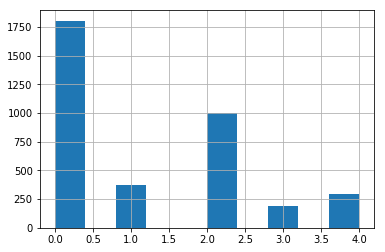

In [9]:
train.diagnosis.hist()

The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.

### Lets Visualize one of the image

In [10]:
im = Image.open(df.path[2])

In [11]:
print(im.size)

(3216, 2136)


How do we know that a patient have diabetic retinopahy? [There are at least 5 things to spot on.](https://www.eyeops.com/contents/our-services/eye-diseases/diabetic-retinopathy)

<center>
<img src="images/Diabetic-Retinopathy.jpeg" />
</center>

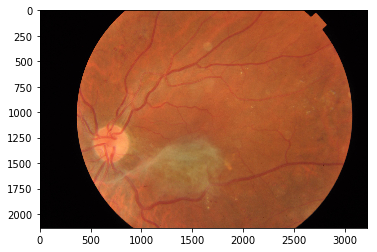

In [12]:
plt.imshow(np.asarray(im))

From quick investigations of the data (see various pictures below), I found that Hemorrphages, Hard Exudates and Cotton Wool spots are quite easily observed. However, I still could not find examples of Aneurysm or Abnormal Growth of Blood Vessels from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

we will see, images come with many different lighting conditions, some images are very dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, there is a better approach. We can try the method of Ben Graham (last competition's winner)

<https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition>

Distinct stages in diabetic retinopathy

In [14]:
train['diagnosis'].unique()

array([2, 4, 1, 0, 3])

Visualizing some random images from each class

In [15]:
def showbyserverity():
    fig = plt.figure(figsize=(25, 16))
    for class_id in sorted(train['diagnosis'].unique()): 
        for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=42).iterrows()):
            ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
            path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (512, 512))

            plt.imshow(image)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

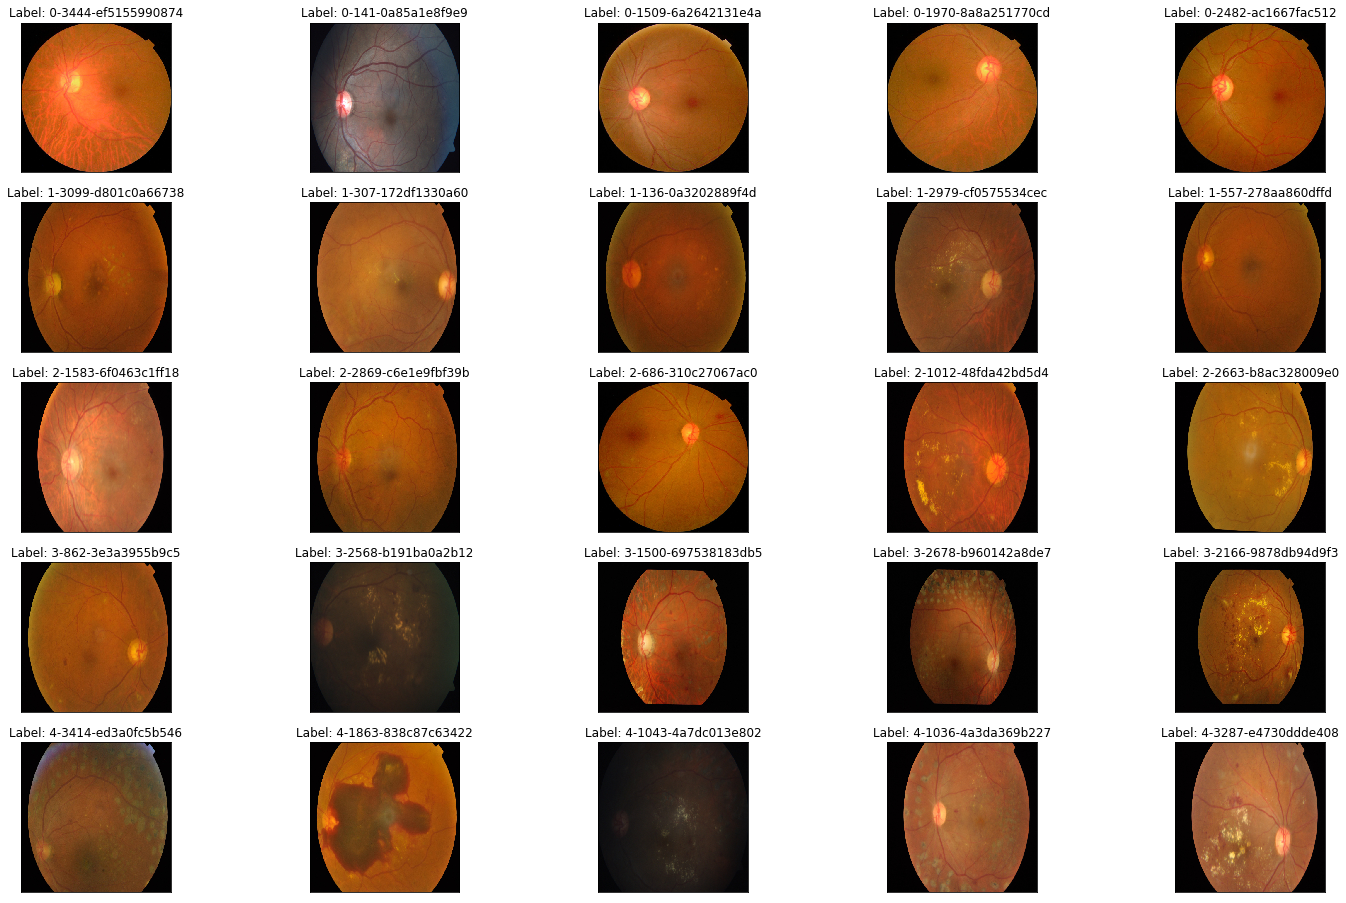

In [16]:
showbyserverity()

Visualizing some random grayscale images from each class

In [17]:
def showbyserverity_GRAY():
    fig = plt.figure(figsize=(25, 16))
    for class_id in sorted(train['diagnosis'].unique()): 
        for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=42).iterrows()):
            ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
            path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (512, 512))

            plt.imshow(image)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

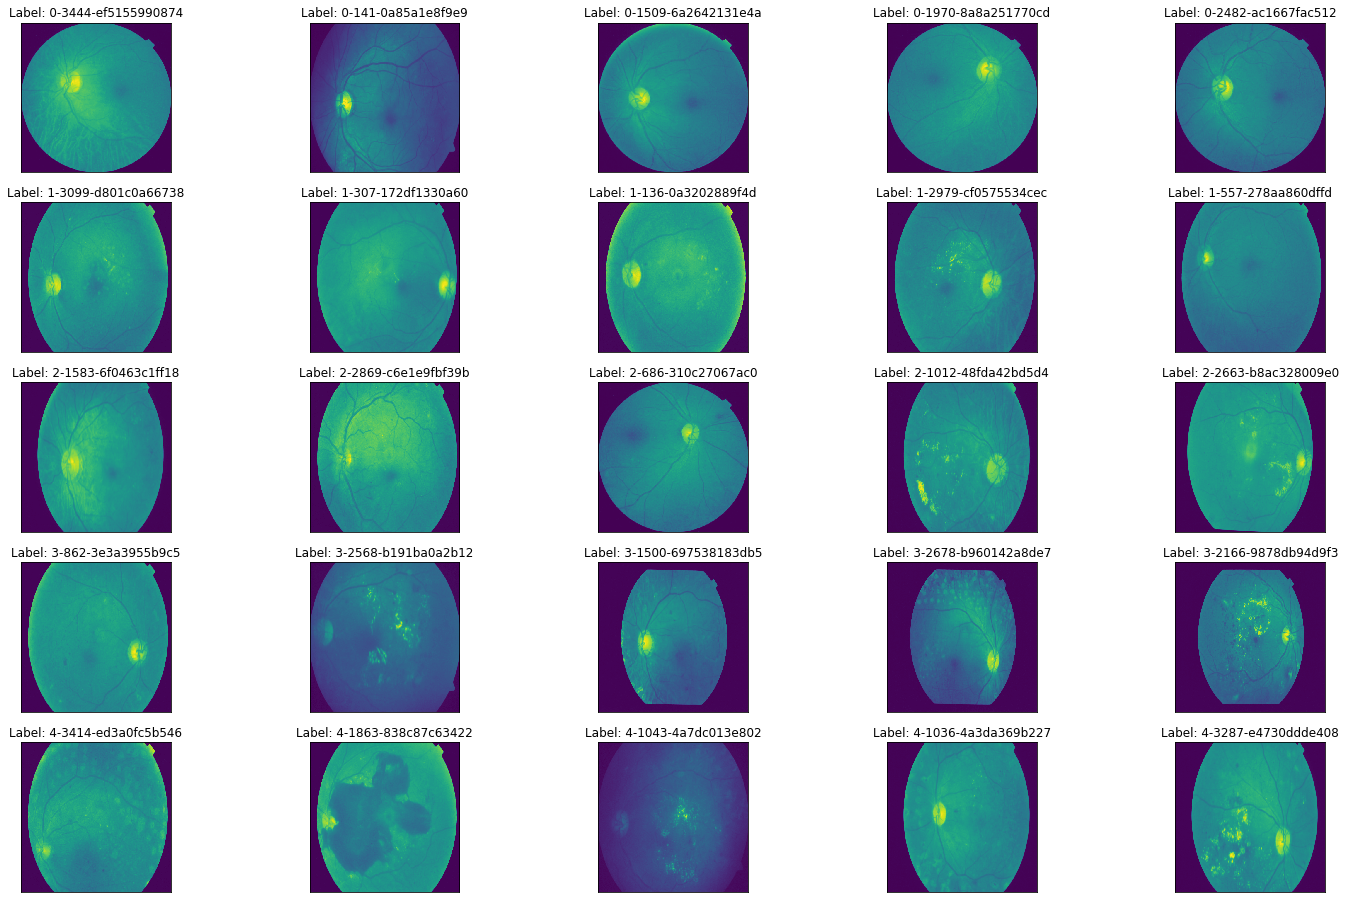

In [18]:
showbyserverity_GRAY()

In [19]:
train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [20]:
train_image=[]
train_label=[]

One Hot encoding for each class

In [21]:
def label_img(name):
    if name == 0 : 
        return np.array([1, 0, 0, 0, 0])
    elif name == 1 : 
        return np.array([0, 1, 0, 0, 0])
    elif name == 2 : 
        return np.array([0, 0, 1, 0, 0])
    elif name == 3 : 
        return np.array([0, 0, 0, 1, 0])
    else:
        return np.array([0, 0, 0, 0, 1 ])

Resizing each image to 256 * 256 and converting to numoy array and label to one hot encoding value

In [22]:
for i,j in train.values:
    path=f"../input/aptos2019-blindness-detection/train_images/{i}.png"
    image = cv2.imread(path)
    label = label_img(j)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    train_image.append(np.array(image)/255)
    train_label.append(label)
    
    

Spliting the dataset into train, test and validation sets 

In [24]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(train_image, train_label, test_size = 0.25, random_state = 42)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size = 0.15, random_state = 42)

In [25]:
xTrain[123].shape

(224, 224, 3)

Converting each data component to numpy array 

In [26]:
xTrain = np.array(xTrain)
xTest = np.array(xTest)



In [27]:
yTrain = np.array(yTrain)
yTest = np.array(yTest)

In [28]:
xVal = np.array(xVal)
yVal = np.array(yVal)

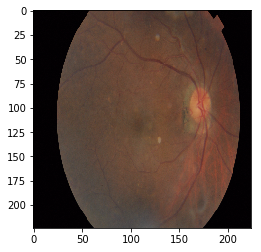

In [29]:
import matplotlib.pyplot as plt
plt.imshow(xTrain[219], cmap = 'gist_gray')

### Deep Learning Model - Baseline  

The rectified linear activation function is a piecewise linear function that will output the input directly if is positive, otherwise, it will output zero.
We can define cross entropy as the difference between two probability distributions p and q, where p is our true output and q is our estimate of this true output.
This difference is now applied to our neural networks, where it is extremely effective because of their strong usage of probability.

Batch Normalization Layer - We normalize the input layer by adjusting and scaling the activations. For example, when we have features from 0 to 1 and some from 1 to 1000, we should normalize them to speed up learning. If the input layer is benefiting from it, why not do the same thing also for the values in the hidden layers, that are changing all the time, and get 10 times or more improvement in the training speed.

A pooling layer that reduces the image dimensionality without losing important features or patterns.

Flatten is used to flatten the input. For example, if flatten is applied to layer having input shape as (batch_size, 2,2), then the output shape of the layer will be (batch_size, 4)

A fully connected layer also known as the dense layer, in which the results of the convolutional layers are fed through one or more neural layers to generate a prediction.

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2))) # Calculate the maximum value for each patch of the feature map.
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization()) #  batch normalization allows each layer of a network to learn by itself a little bit more independently of other layers.
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation = 'softmax'))

Using TensorFlow backend.


In [32]:
from keras.optimizers import SGD
from keras import metrics
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='adam')

In [33]:
from keras.callbacks import ModelCheckpoint

In [34]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [35]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 11s 5ms/step - loss: 0.9700 - categorical_accuracy: 0.6620 - val_loss: 1.5492 - val_categorical_accuracy: 0.2694

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26942, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7675 - categorical_accuracy: 0.7177 - val_loss: 1.5136 - val_categorical_accuracy: 0.2694

Epoch 00002: val_categorical_accuracy did not improve from 0.26942
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7260 - categorical_accuracy: 0.7305 - val_loss: 2.1067 - val_categorical_accuracy: 0.2694

Epoch 00003: val_categorical_accuracy did not improve from 0.26942
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7017 - categorical_accuracy: 0.7468 - val_loss: 1.7030 - val_categorical_accuracy: 0.2694

Epoch 00004: val_categorical_accuracy d

In [36]:
model.load_weights('best_weights.hdf5')

In [37]:
model.save('model_adam_40.h5')

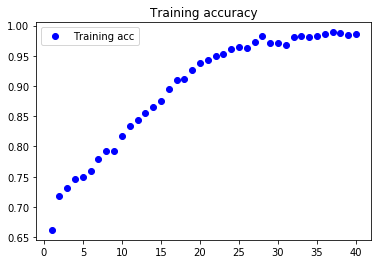

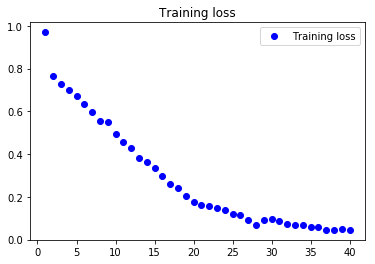

In [38]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [39]:
yPred = model.predict(xTest)

In [40]:
result = []
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)


In [41]:
resultt=[]
for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [42]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

In [43]:
f1_score(result,resultt,average='macro')

0.5099912556546209

In [44]:
accuracy_score(result,resultt)

0.7565502183406113

In [45]:
confusion_matrix(result,resultt)

array([[443,  11,  15,   2,   9],
       [  5,  37,  27,   6,   5],
       [  2,  31, 190,  27,  48],
       [  0,   1,   5,   5,   4],
       [  0,   1,  20,   4,  18]])

It reached network pleateau at around 25 epochs

### Activation Functions

Model - With leaky Relu

A leaky ReLU layer performs a threshold operation, where any input value less than zero is multiplied by a fixed scalar.

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LeakyReLU
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), input_shape=(224, 224, 3)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.05))
model.add(Dense(5, activation = 'softmax'))

In [48]:

from keras import metrics
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='adam')

In [49]:
from keras.callbacks import ModelCheckpoint

In [50]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [51]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 7s 3ms/step - loss: 0.9542 - categorical_accuracy: 0.6658 - val_loss: 1.5199 - val_categorical_accuracy: 0.2694

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26942, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7596 - categorical_accuracy: 0.7241 - val_loss: 1.4198 - val_categorical_accuracy: 0.3204

Epoch 00002: val_categorical_accuracy improved from 0.26942 to 0.32039, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7171 - categorical_accuracy: 0.7382 - val_loss: 1.5112 - val_categorical_accuracy: 0.4612

Epoch 00003: val_categorical_accuracy improved from 0.32039 to 0.46117, saving model to best_weights.hdf5
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.6905 - categorical_accuracy: 0.7429 - val_loss: 1.284

In [52]:
model.load_weights('best_weights.hdf5')

In [53]:
model.save('model_adam_40_LRelu.h5')

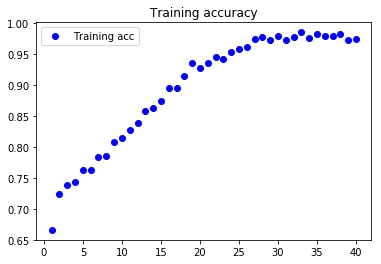

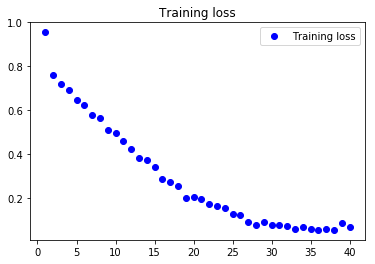

In [54]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [55]:
yPred = model.predict(xTest)

In [56]:
result = []
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

In [57]:
resultt=[]
for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [58]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score

In [59]:

confusion_matrix(result,resultt)


array([[438,  16,  24,   4,  11],
       [  7,  36,  31,   5,  12],
       [  5,  25, 190,  24,  53],
       [  0,   2,   5,   8,   2],
       [  0,   2,   7,   3,   6]])

In [60]:

accuracy_score(result,resultt)

0.740174672489083

In [61]:
f1_score(result,resultt,average='macro')

0.48268350572753393

##### This model too reached network plateau at around 30 epochs

### Model with tanh activation function

It is nonlinear in nature, so great we can stack layers! It is bound to range (-1, 1) so no worries of activations blowing up. One point to mention is that the gradient is stronger for tanh than sigmoid ( derivatives are steeper). Deciding between the sigmoid or tanh will depend on your requirement of gradient strength. Like sigmoid, tanh also has the vanishing gradient problem

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='tanh', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(5, activation = 'softmax'))

In [64]:

from keras import metrics
from keras.callbacks import ModelCheckpoint
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='adam')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [65]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 8s 3ms/step - loss: 1.0068 - categorical_accuracy: 0.6350 - val_loss: 1.6411 - val_categorical_accuracy: 0.3617

Epoch 00001: val_categorical_accuracy improved from -inf to 0.36165, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 6s 3ms/step - loss: 0.8912 - categorical_accuracy: 0.6808 - val_loss: 1.0546 - val_categorical_accuracy: 0.6408

Epoch 00002: val_categorical_accuracy improved from 0.36165 to 0.64078, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.8618 - categorical_accuracy: 0.6902 - val_loss: 0.9849 - val_categorical_accuracy: 0.6456

Epoch 00003: val_categorical_accuracy improved from 0.64078 to 0.64563, saving model to best_weights.hdf5
Epoch 4/40
2334/2334 [==============================] - 6s 2ms/step - loss: 0.8142 - categorical_accuracy: 0.6911 - val_loss: 0.882

In [66]:
model.load_weights('best_weights.hdf5')

In [67]:
model.save('model_adam_40_Tanh.h5')

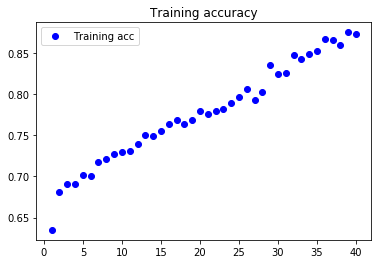

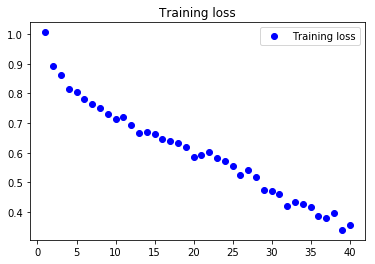

In [68]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [69]:
yPred = model.predict(xTest)

In [70]:
result = []
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)
resultt=[]
for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [71]:
confusion_matrix(result,resultt)

array([[437,  16,  29,   7,  12],
       [  6,  40,  31,   4,  13],
       [  7,  21, 180,  20,  41],
       [  0,   2,  12,   9,   9],
       [  0,   2,   5,   4,   9]])

In [72]:
accuracy_score(result,resultt)

0.7368995633187773

In [73]:
f1_score(result,resultt,average='macro')

0.49410102582736126

Other Activation Functions 

PReLU. - PReLU gives the neurons the ability to choose what slope is best in the negative region. They can become a ReLU or a leaky ReLU with certain values of α.

ELU - The exponential Linear Unit leads to higher classification results than traditional ReLU. It follows the same rule for x>= 0 as ReLU, and increases exponentially for x < 0.ELU tries to make the mean activations closer to zero which speeds up training.

Maxout - The Maxout activation is a generalization of the ReLU and the leaky ReLU functions.

##### The Network plateau is not determined in 40 epochs

### Different Cost Functions

Quadratic cost (mean-square error)

Cross-Entropy

Hinge

Kullback–Leibler divergence

Cosine Proximity

We will try different cost functions

Using MSE as Cost Function

The difference between our estimate of y and the true value of y is taken and squared. This square isn’t there for no reason, as it allows are result to be quadratic.We know that a quadratic function when plotted will always have a sort of ‘u’ shape making it convex.
This shows us that in the future when we need to use something like gradient descent, we won’t run into the major problem of getting stuck in a local optimum


In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax'))

In [75]:

from keras import metrics
from keras.callbacks import ModelCheckpoint
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', metrics = [metrics.categorical_accuracy], optimizer='adam')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [76]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 6s 3ms/step - loss: 0.0931 - categorical_accuracy: 0.6735 - val_loss: 0.1750 - val_categorical_accuracy: 0.2694

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26942, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.0778 - categorical_accuracy: 0.7215 - val_loss: 0.1874 - val_categorical_accuracy: 0.2694

Epoch 00002: val_categorical_accuracy did not improve from 0.26942
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.0760 - categorical_accuracy: 0.7348 - val_loss: 0.1606 - val_categorical_accuracy: 0.2694

Epoch 00003: val_categorical_accuracy did not improve from 0.26942
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.0707 - categorical_accuracy: 0.7429 - val_loss: 0.1329 - val_categorical_accuracy: 0.5680

Epoch 00004: val_categorical_accuracy im

In [77]:
model.load_weights('best_weights.hdf5')
model.save('model_adam_40_mse.h5')

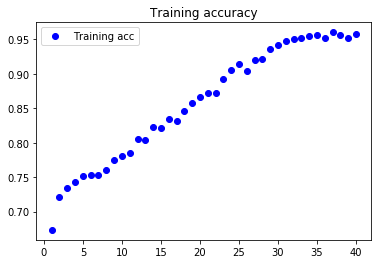

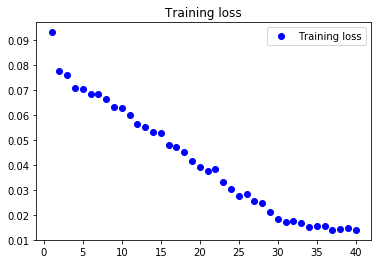

In [78]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [79]:
yPred = model.predict(xTest)

In [80]:
result = []
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)
resultt=[]
for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [81]:

print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_Score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.7510917030567685
f1_Score :0.50194112898161


array([[439,  14,  21,   1,  10],
       [  4,  32,  21,   5,  13],
       [  6,  31, 196,  22,  45],
       [  1,   1,  13,   8,   3],
       [  0,   3,   6,   8,  13]])

##### The Network plateau is reached after 35 Epochs when we used MSE as cost function

### Kullback–Leibler divergence

We should also note another common cost function used that is very similar to cross entropy, called KL Divergence. In fact, it’s pretty much a mutated cross entropy, and can also be referred to as relative entropy

This means that when applied to our data, the KL divergence will never be less than 0. It is only equal to 0 if p = q. Also note that the KL divergence is not a distance, whereas the cross entropy is

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation = 'softmax'))

In [83]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
model.compile(loss='kullback_leibler_divergence', metrics = [metrics.categorical_accuracy], optimizer='adam')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [84]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 7s 3ms/step - loss: 0.9324 - categorical_accuracy: 0.6671 - val_loss: 1.5268 - val_categorical_accuracy: 0.1869

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18689, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7737 - categorical_accuracy: 0.7108 - val_loss: 1.3236 - val_categorical_accuracy: 0.4612

Epoch 00002: val_categorical_accuracy improved from 0.18689 to 0.46117, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7423 - categorical_accuracy: 0.7207 - val_loss: 1.7181 - val_categorical_accuracy: 0.2694

Epoch 00003: val_categorical_accuracy did not improve from 0.46117
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7069 - categorical_accuracy: 0.7399 - val_loss: 1.2432 - val_categorical_accuracy: 0.5874

E

In [85]:
model.load_weights('best_weights.hdf5')
model.save('model_adam_40_KL_Divergence.h5')

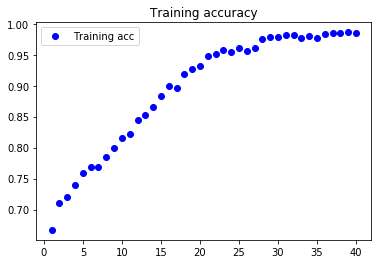

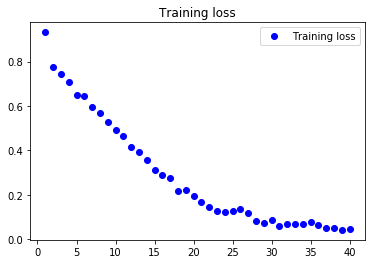

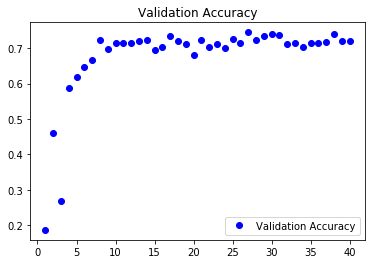

In [86]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()


In [87]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)


In [88]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.730349344978166
f1_score :0.4641037818151233


array([[442,  14,  16,   3,   7],
       [  5,  30,  29,   5,  13],
       [  2,  33, 181,  24,  49],
       [  1,   3,  20,   8,   7],
       [  0,   1,  11,   4,   8]])

##### Network Pleteau for training accuracy is reached at around 30 epochs

### Gradient Estimation

Using Stochastic Gradient Descent

SGD randomly picks one data point from the whole data set at each iteration to reduce the computations enormously.
It is also common to sample a small number of data points instead of just one point at each step and that is called “mini-batch” gradient descent. Mini-batch tries to strike a balance between the goodness of gradient descent and speed of SGD.

In [90]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation = 'softmax'))

In [91]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer=sgd)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [92]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 6s 3ms/step - loss: 0.9739 - categorical_accuracy: 0.6607 - val_loss: 1.5474 - val_categorical_accuracy: 0.2913

Epoch 00001: val_categorical_accuracy improved from -inf to 0.29126, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7670 - categorical_accuracy: 0.7232 - val_loss: 1.2333 - val_categorical_accuracy: 0.5631

Epoch 00002: val_categorical_accuracy improved from 0.29126 to 0.56311, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7189 - categorical_accuracy: 0.7301 - val_loss: 1.3482 - val_categorical_accuracy: 0.4393

Epoch 00003: val_categorical_accuracy did not improve from 0.56311
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.6927 - categorical_accuracy: 0.7429 - val_loss: 1.0739 - val_categorical_accuracy: 0.6044

E

In [93]:
model.load_weights('best_weights.hdf5')
model.save('model_adam_40_KL_Divergence.h5')

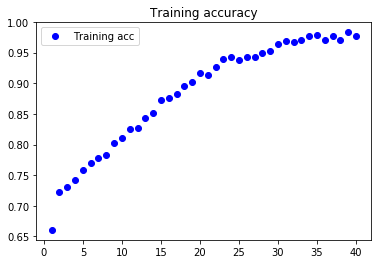

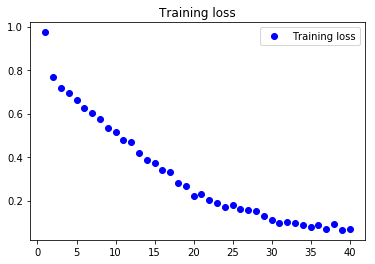

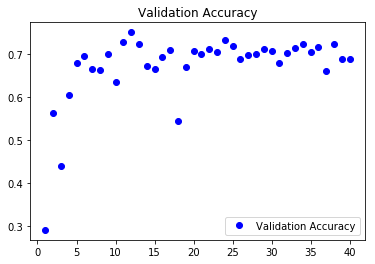

In [94]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()



In [95]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)



In [96]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.732532751091703
f1_score :0.45695601731891233


array([[441,  13,  21,   5,  12],
       [  4,  23,  23,   6,   7],
       [  4,  39, 191,  26,  53],
       [  0,   1,   7,   5,   1],
       [  1,   5,  15,   2,  11]])

##### Network Pleateu is reached at around 30 epochs

#### RMSProp

Algorithm :

1.First, we look at the signs of the last two gradients for the weight.

2.If they have the same sign, that means, we’re going in the right direction, and should accelerate it by a small fraction, meaning we should increase the step size multiplicatively(e.g by a factor of 1.2). If they’re different, that means we did too large of a step and jumped over a local minima, thus we should decrease the step size multiplicatively(e.g. by a factor of 0.5).

3.Then, we limit the step size between some two values. These values really depend on your application and dataset, good values that can be for default are 50 and a millionth, which is a good start.

4.Now we can apply the weight update.

In [97]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax'))

In [98]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='rmsprop')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [99]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 6s 3ms/step - loss: 0.9976 - categorical_accuracy: 0.6512 - val_loss: 1.6067 - val_categorical_accuracy: 0.1286

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12864, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.8021 - categorical_accuracy: 0.7138 - val_loss: 2.0258 - val_categorical_accuracy: 0.2694

Epoch 00002: val_categorical_accuracy improved from 0.12864 to 0.26942, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7684 - categorical_accuracy: 0.7301 - val_loss: 1.4509 - val_categorical_accuracy: 0.3107

Epoch 00003: val_categorical_accuracy improved from 0.26942 to 0.31068, saving model to best_weights.hdf5
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7316 - categorical_accuracy: 0.7348 - val_loss: 1.272

In [100]:
model.load_weights('best_weights.hdf5')
model.save('model_rms_40.h5')

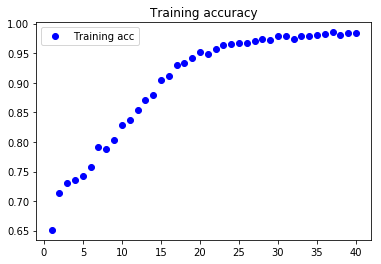

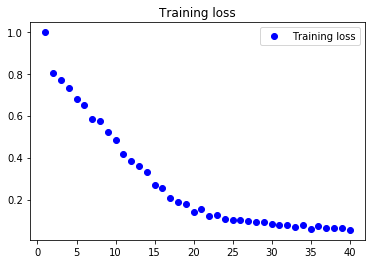

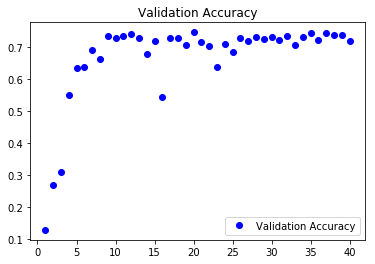

In [101]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()



In [102]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)



In [103]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.7368995633187773
f1_score :0.47793817306952013


array([[437,  11,  14,   6,   8],
       [ 11,  38,  28,   2,   8],
       [  2,  28, 182,  25,  51],
       [  0,   1,   9,   3,   2],
       [  0,   3,  24,   8,  15]])

##### Network plateau is reached at around 20 epochs

#### Adagrad Optimizer

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing smaller updates
(i.e. low learning rates) for parameters associated with frequently occurring features, and larger updates (i.e. high learning rates) for parameters associated with infrequent features.

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax'))

In [105]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='adagrad')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [106]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 7s 3ms/step - loss: 1.3285 - categorical_accuracy: 0.6161 - val_loss: 1.4811 - val_categorical_accuracy: 0.3398

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33981, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7952 - categorical_accuracy: 0.6971 - val_loss: 1.5296 - val_categorical_accuracy: 0.2670

Epoch 00002: val_categorical_accuracy did not improve from 0.33981
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7217 - categorical_accuracy: 0.7305 - val_loss: 1.4972 - val_categorical_accuracy: 0.2816

Epoch 00003: val_categorical_accuracy did not improve from 0.33981
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7004 - categorical_accuracy: 0.7279 - val_loss: 1.3390 - val_categorical_accuracy: 0.3859

Epoch 00004: val_categorical_accuracy im

In [107]:
model.load_weights('best_weights.hdf5')
model.save('model_adagrad_40.h5')

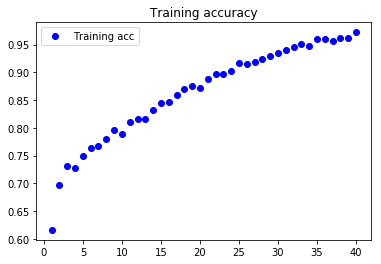

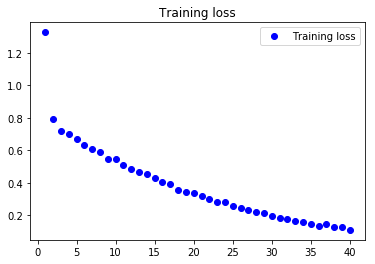

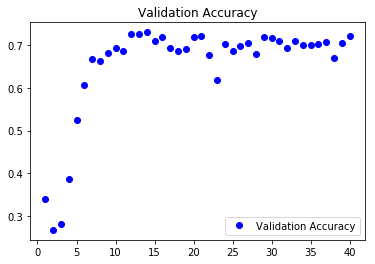

In [108]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()

In [109]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:       
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)



In [110]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.7314410480349345
f1_score :0.4772188331896448


array([[438,   9,  23,   4,  11],
       [  7,  33,  28,   2,   7],
       [  5,  30, 181,  24,  49],
       [  0,   3,  10,   6,   5],
       [  0,   6,  15,   8,  12]])

##### Network Pleateu reached at around 30 epochs

### Network weights Initiaization

#### Kernel_Initializer is uniform

Initializer that generates a truncated normal distribution

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='uniform',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='uniform'))
model.add(Dense(5, activation = 'softmax',kernel_initializer='uniform'))

In [112]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='rmsprop')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [113]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 7s 3ms/step - loss: 0.8863 - categorical_accuracy: 0.6744 - val_loss: 1.5674 - val_categorical_accuracy: 0.1286

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12864, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7742 - categorical_accuracy: 0.7147 - val_loss: 1.5357 - val_categorical_accuracy: 0.2694

Epoch 00002: val_categorical_accuracy improved from 0.12864 to 0.26942, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7223 - categorical_accuracy: 0.7318 - val_loss: 1.4195 - val_categorical_accuracy: 0.2718

Epoch 00003: val_categorical_accuracy improved from 0.26942 to 0.27184, saving model to best_weights.hdf5
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.6795 - categorical_accuracy: 0.7481 - val_loss: 1.389

In [114]:
model.load_weights('best_weights.hdf5')
model.save('model_adagrad_40_NI.h5')

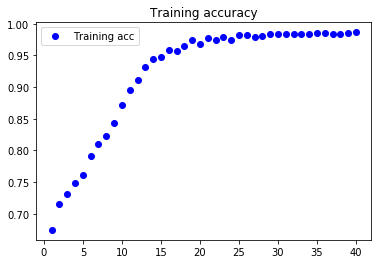

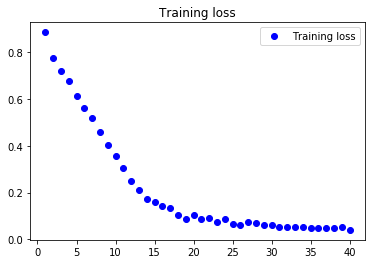

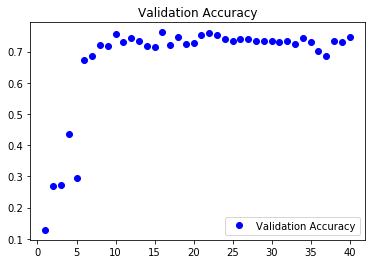

In [115]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()

In [116]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:       
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [117]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.740174672489083
f1_score :0.5309023429045437


array([[434,  13,  14,   1,   3],
       [ 10,  33,  23,   2,   7],
       [  5,  27, 175,  16,  43],
       [  0,   3,  23,  16,  11],
       [  1,   5,  22,   9,  20]])

#### The Network Pleateu reached at 15 epochs

#### Kernel Initializer is He_normal

In this method, the weights are initialized keeping in mind the size of the previous layer which helps in attaining a global minimum of the cost function faster and more efficiently.The weights are still random but differ in range depending on the size of the previous layer of neurons. This provides a controlled initialization hence the faster and more efficient gradient descent

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(5, activation = 'softmax',kernel_initializer='he_normal'))

In [119]:
from keras import metrics
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='rmsprop')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [120]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 7s 3ms/step - loss: 0.9406 - categorical_accuracy: 0.6718 - val_loss: 1.4751 - val_categorical_accuracy: 0.2791

Epoch 00001: val_categorical_accuracy improved from -inf to 0.27913, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7780 - categorical_accuracy: 0.7138 - val_loss: 1.2895 - val_categorical_accuracy: 0.4612

Epoch 00002: val_categorical_accuracy improved from 0.27913 to 0.46117, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7321 - categorical_accuracy: 0.7352 - val_loss: 1.2443 - val_categorical_accuracy: 0.5267

Epoch 00003: val_categorical_accuracy improved from 0.46117 to 0.52670, saving model to best_weights.hdf5
Epoch 4/40
2334/2334 [==============================] - 5s 2ms/step - loss: 0.6808 - categorical_accuracy: 0.7489 - val_loss: 1.106

In [121]:
model.load_weights('best_weights.hdf5')
model.save('model_adagrad_40_hI.h5')

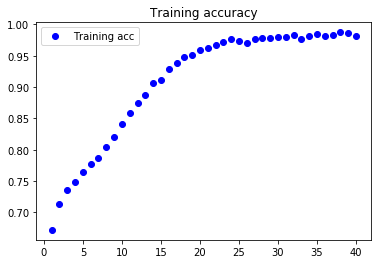

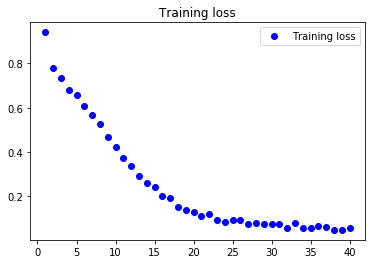

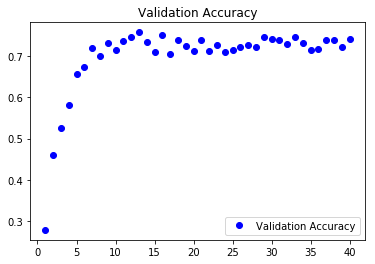

In [122]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()

In [123]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:      
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [124]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.732532751091703
f1_score :0.5106370172197301


array([[430,  11,  17,   1,   5],
       [  6,  42,  27,   3,  13],
       [  8,  16, 167,  21,  37],
       [  3,   2,   7,   5,   2],
       [  3,  10,  39,  14,  27]])

#### The Network Plaetau reached at around 25 epochs

### Network Architecture

We will try architecture different from the previous one based on this research paper :

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&ved=2ahUKEwjQht2_kdLoAhUshXIEHfB1CwIQFjACegQIBBAB&url=http%3A%2F%2Fwww.mdpi.com%2F1420-3049%2F22%2F12%2F2054%2Fpdf&usg=AOvVaw1qrDgjP6hiUOyVq6IQGPeH

In [125]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='uniform',input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(Conv2D(64, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(Conv2D(256, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(4096, activation='relu',kernel_initializer='uniform'))
model.add(Dense(1024, activation='relu',kernel_initializer='uniform'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax',kernel_initializer='uniform'))

In [126]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 51, 51, 128)     

In [127]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='rmsprop')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [128]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=40,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/40
2334/2334 [==============================] - 11s 5ms/step - loss: 2.3514 - categorical_accuracy: 0.4751 - val_loss: 1.2689 - val_categorical_accuracy: 0.6117

Epoch 00001: val_categorical_accuracy improved from -inf to 0.61165, saving model to best_weights.hdf5
Epoch 2/40
2334/2334 [==============================] - 9s 4ms/step - loss: 1.0471 - categorical_accuracy: 0.6444 - val_loss: 0.9736 - val_categorical_accuracy: 0.6286

Epoch 00002: val_categorical_accuracy improved from 0.61165 to 0.62864, saving model to best_weights.hdf5
Epoch 3/40
2334/2334 [==============================] - 9s 4ms/step - loss: 0.8828 - categorical_accuracy: 0.6911 - val_loss: 0.9387 - val_categorical_accuracy: 0.6602

Epoch 00003: val_categorical_accuracy improved from 0.62864 to 0.66019, saving model to best_weights.hdf5
Epoch 4/40
2334/2334 [==============================] - 9s 4ms/step - loss: 0.8197 - categorical_accuracy: 0.7151 - val_loss: 1.02

In [129]:
model.load_weights('best_weights.hdf5')
model.save('model_rms_40_New.h5')

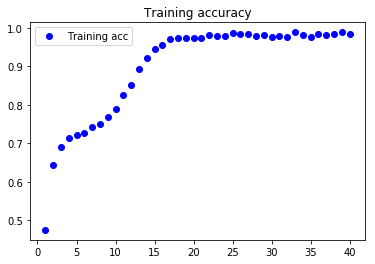

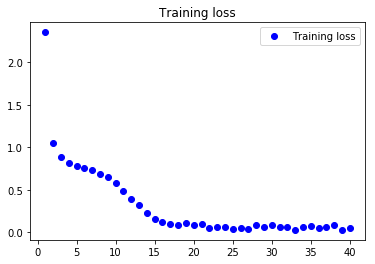

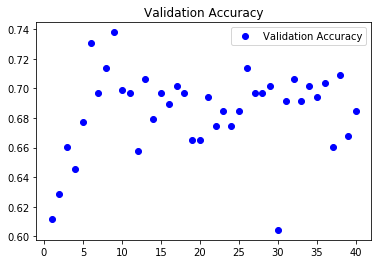

In [130]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()

In [131]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [132]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.7205240174672489
f1_score :0.4725169394600286


array([[426,  13,  28,   5,  11],
       [  8,  42,  39,   7,  15],
       [ 16,  21, 177,  26,  46],
       [  0,   1,   7,   5,   2],
       [  0,   4,   6,   1,  10]])

#### Network Pleateu reached at around 15 epochs

### Epochs

We will change the number of epochs for best model which reached network plateau soon:

In [133]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='uniform',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='uniform'))
#model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax',kernel_initializer='uniform'))

In [134]:
from keras import metrics
from keras.callbacks import ModelCheckpoint
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics = [metrics.categorical_accuracy], optimizer='rmsprop')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_categorical_accuracy',verbose=1, save_best_only=True)

In [135]:
history = model.fit(xTrain, yTrain, batch_size=32, epochs=20,callbacks=[checkpointer],validation_data=(xVal,yVal))

Train on 2334 samples, validate on 412 samples
Epoch 1/20
2334/2334 [==============================] - 6s 3ms/step - loss: 0.8777 - categorical_accuracy: 0.6757 - val_loss: 1.5240 - val_categorical_accuracy: 0.2694

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26942, saving model to best_weights.hdf5
Epoch 2/20
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7714 - categorical_accuracy: 0.7048 - val_loss: 1.7232 - val_categorical_accuracy: 0.2694

Epoch 00002: val_categorical_accuracy did not improve from 0.26942
Epoch 3/20
2334/2334 [==============================] - 5s 2ms/step - loss: 0.7345 - categorical_accuracy: 0.7292 - val_loss: 1.6130 - val_categorical_accuracy: 0.2694

Epoch 00003: val_categorical_accuracy did not improve from 0.26942
Epoch 4/20
2334/2334 [==============================] - 5s 2ms/step - loss: 0.6887 - categorical_accuracy: 0.7408 - val_loss: 1.3867 - val_categorical_accuracy: 0.3301

Epoch 00004: val_categorical_accuracy im

In [136]:
model.load_weights('best_weights.hdf5')
model.save('model_rms_40_LM.h5')

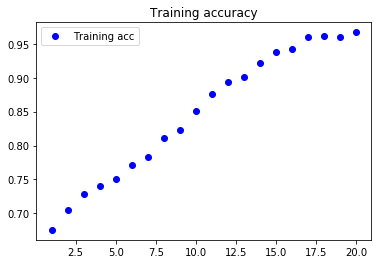

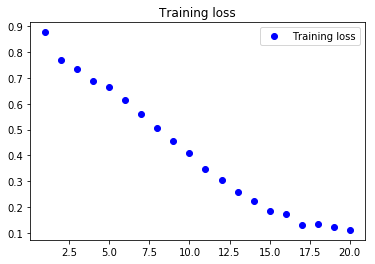

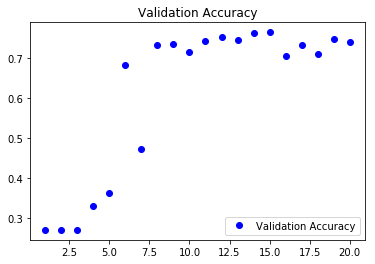

In [137]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()



plt.show()

In [138]:
yPred = model.predict(xTest)
result = []
resultt=[]
for i in range(len(yPred)):
    index = np.argmax(yPred[i])
    if index == 0:        
        result.append(0)
    elif index == 1: 
        result.append(1)
    elif index == 2: 
        result.append(2)
    elif index == 3:
        result.append(3)
    elif index == 4:
        result.append(4)

for i in range(len(yTest)):
    index = np.argmax(yTest[i])
    
    if index == 0:        
        resultt.append(0)
    elif index == 1: 
        resultt.append(1)
    elif index == 2: 
        resultt.append(2)
    elif index == 3:
        resultt.append(3)
    elif index == 4:
        resultt.append(4)

In [139]:
print('Accuracy_Score :' + str(accuracy_score(result,resultt)))
print('f1_score :'+ str(f1_score(result,resultt,average='macro')))
confusion_matrix(result,resultt)

Accuracy_Score :0.7467248908296943
f1_score :0.48363345914935385


array([[437,  13,  16,   1,   3],
       [ 12,  43,  37,   7,  16],
       [  1,  24, 191,  27,  58],
       [  0,   1,   8,   6,   0],
       [  0,   0,   5,   3,   7]])

#### We cant find Significant network plateau with lesser number of epochs

## Visualization

In [140]:
img_tensor = xTest[0]
img_tensor = np.expand_dims(img_tensor, axis=0)


print(img_tensor.shape)

(1, 224, 224, 3)


In [141]:
from keras import models

In [142]:
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [143]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [144]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 222, 222, 32)


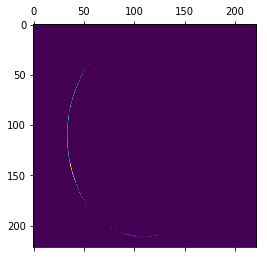

In [145]:
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


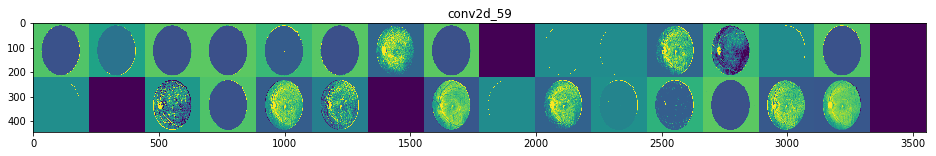

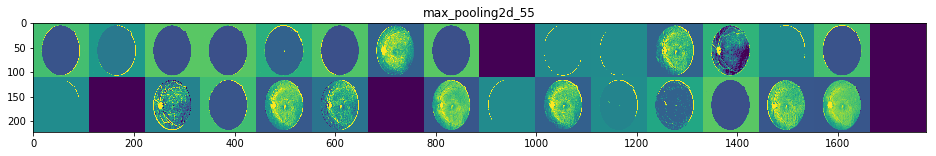

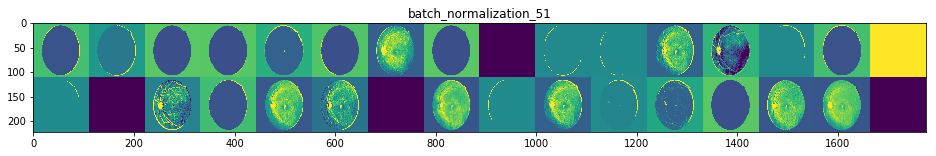

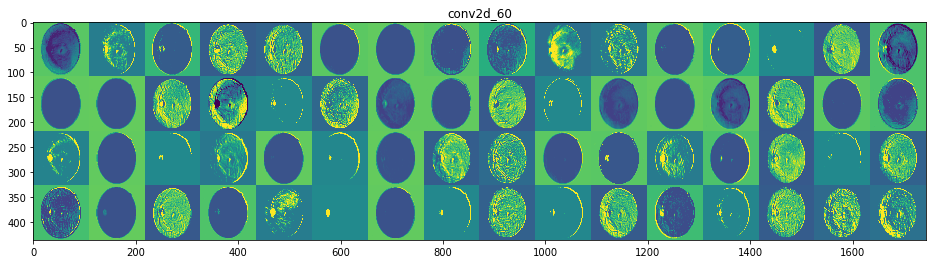

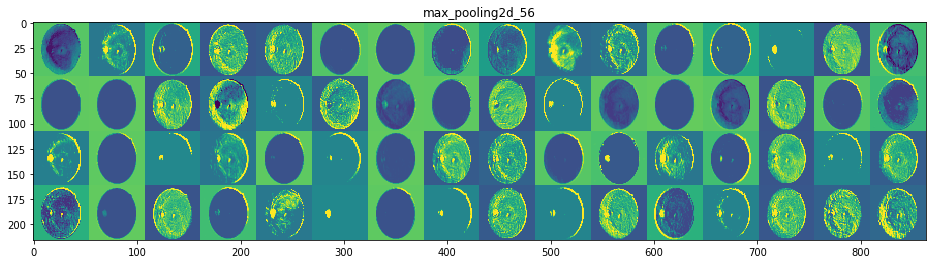

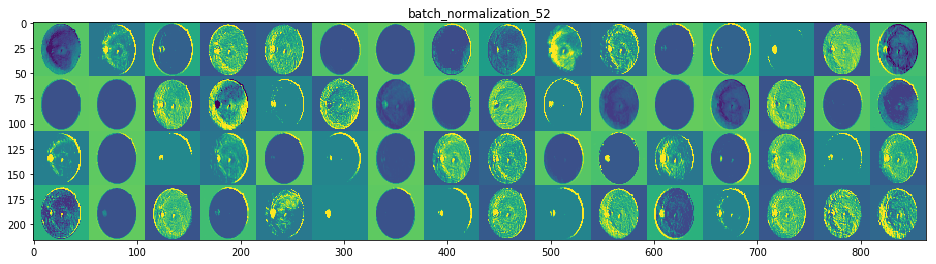

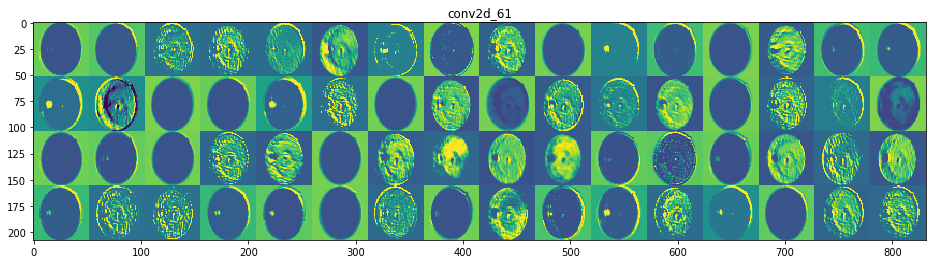

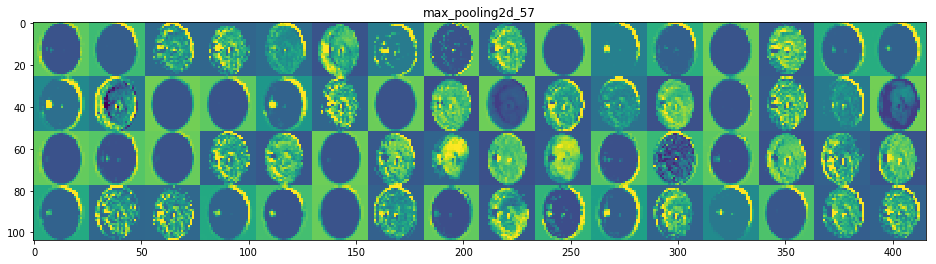

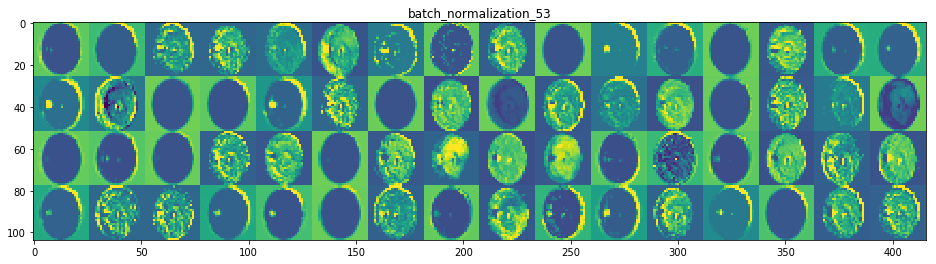

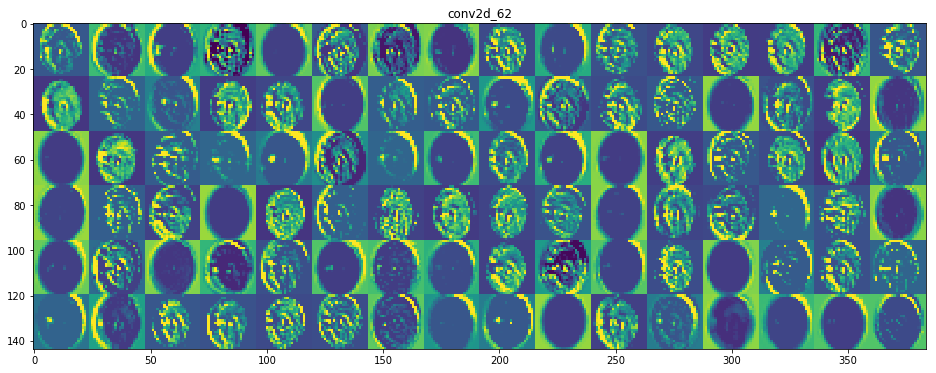

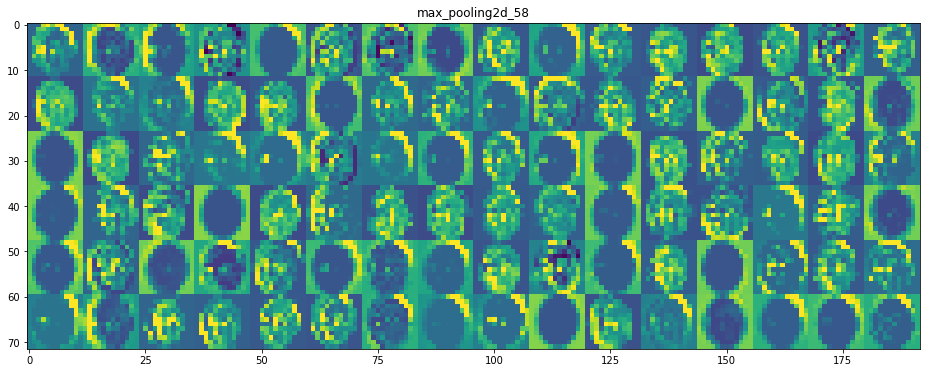

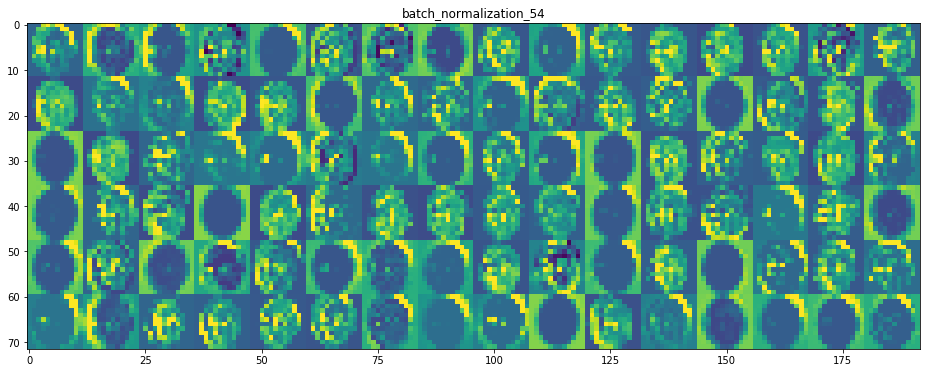

In [146]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

We can see that fourth Convolution layer  is identifying Hemorrphages, Hard Exudates and Cotton Wool spots 

### Conclusion

We have found better hyperparameters for the model which will help to train model with less number of epochs and better accuracy than the baseline model which are being usedwith data augmnetation dataset

### License

Copyright 2020 Satya Ikyath Varma Dantuluri

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### References

https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044

https://medium.com/machine-learning-for-li/a-walk-through-of-cost-functions-4767dff78f7

https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404